In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report




In [ ]:
#load dataset
df = pd.read_csv("motioniq_cleaned_dataset.csv")
print(df.head())
print(df['activity'].value_counts())


In [5]:
#preprocess for RNN
# Label encode target
le = LabelEncoder()
y_encoded = le.fit_transform(df['activity'])
num_classes = len(le.classes_)

# Drop irrelevant cols
X = df.drop(columns=['subject', 'activity_id', 'activity', 'timestamp', 'datetime'], errors='ignore')
y = y_encoded

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Sequence prep
seq_length = 20  # number of timesteps
X_seq = []
y_seq = []

for i in range(len(X_scaled) - seq_length):
    X_seq.append(X_scaled[i:i+seq_length])
    y_seq.append(y[i + seq_length - 1])  
X_seq = np.array(X_seq)  
y_seq = np.array(y_seq)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

print(f"Train shape: {X_train_t.shape}, Test shape: {X_test_t.shape}")


Train shape: torch.Size([8223, 20, 561]), Test shape: torch.Size([2056, 20, 561])


In [6]:
#Models:
class SimpleRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(SimpleRNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out


In [7]:
#train func
def train_model(model, X_train, y_train, X_val, y_val, epochs=30, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_losses.append(val_loss.item())

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    return train_losses, val_losses



In [8]:
# training models
input_size = X_train_t.shape[2]
hidden_size = 64
num_layers = 1

# Simple RNN
rnn_model = SimpleRNNModel(input_size, hidden_size, num_layers, num_classes)
rnn_train_losses, rnn_val_losses = train_model(rnn_model, X_train_t, y_train_t, X_test_t, y_test_t)

# LSTM
lstm_model = LSTMModel(input_size, hidden_size, num_layers, num_classes)
lstm_train_losses, lstm_val_losses = train_model(lstm_model, X_train_t, y_train_t, X_test_t, y_test_t)

# GRU
gru_model = GRUModel(input_size, hidden_size, num_layers, num_classes)
gru_train_losses, gru_val_losses = train_model(gru_model, X_train_t, y_train_t, X_test_t, y_test_t)


Epoch 1/30, Train Loss: 2.0013, Val Loss: 1.7450
Epoch 5/30, Train Loss: 1.2502, Val Loss: 1.1642
Epoch 10/30, Train Loss: 0.9382, Val Loss: 0.9076
Epoch 15/30, Train Loss: 0.7965, Val Loss: 0.7743
Epoch 20/30, Train Loss: 0.6876, Val Loss: 0.6690
Epoch 25/30, Train Loss: 0.5950, Val Loss: 0.5783
Epoch 30/30, Train Loss: 0.5148, Val Loss: 0.5020
Epoch 1/30, Train Loss: 1.8244, Val Loss: 1.6838
Epoch 5/30, Train Loss: 1.3944, Val Loss: 1.3323
Epoch 10/30, Train Loss: 1.1394, Val Loss: 1.1005
Epoch 15/30, Train Loss: 0.9479, Val Loss: 0.9193
Epoch 20/30, Train Loss: 0.8040, Val Loss: 0.7813
Epoch 25/30, Train Loss: 0.6799, Val Loss: 0.6628
Epoch 30/30, Train Loss: 0.5743, Val Loss: 0.5604
Epoch 1/30, Train Loss: 1.8385, Val Loss: 1.5951
Epoch 5/30, Train Loss: 1.1632, Val Loss: 1.0842
Epoch 10/30, Train Loss: 0.8721, Val Loss: 0.8267
Epoch 15/30, Train Loss: 0.7017, Val Loss: 0.6709
Epoch 20/30, Train Loss: 0.5802, Val Loss: 0.5531
Epoch 25/30, Train Loss: 0.4789, Val Loss: 0.4546
Epoch 

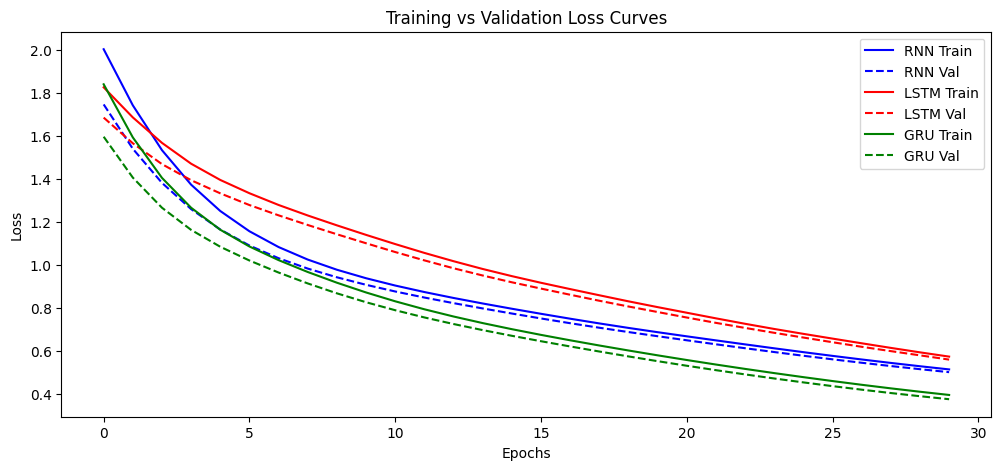

In [9]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        y_pred = predicted.numpy()
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    return acc, f1, cm, y_pred

rnn_acc, rnn_f1, rnn_cm, _ = evaluate_model(rnn_model, X_test_t, y_test)
lstm_acc, lstm_f1, lstm_cm, _ = evaluate_model(lstm_model, X_test_t, y_test)
gru_acc, gru_f1, gru_cm, _ = evaluate_model(gru_model, X_test_t, y_test)

# Plot training curves
plt.figure(figsize=(12,5))
plt.plot(rnn_train_losses, label='RNN Train', color='blue')
plt.plot(rnn_val_losses, label='RNN Val', color='blue', linestyle='--')
plt.plot(lstm_train_losses, label='LSTM Train', color='red')
plt.plot(lstm_val_losses, label='LSTM Val', color='red', linestyle='--')
plt.plot(gru_train_losses, label='GRU Train', color='green')
plt.plot(gru_val_losses, label='GRU Val', color='green', linestyle='--')
plt.title('Training vs Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


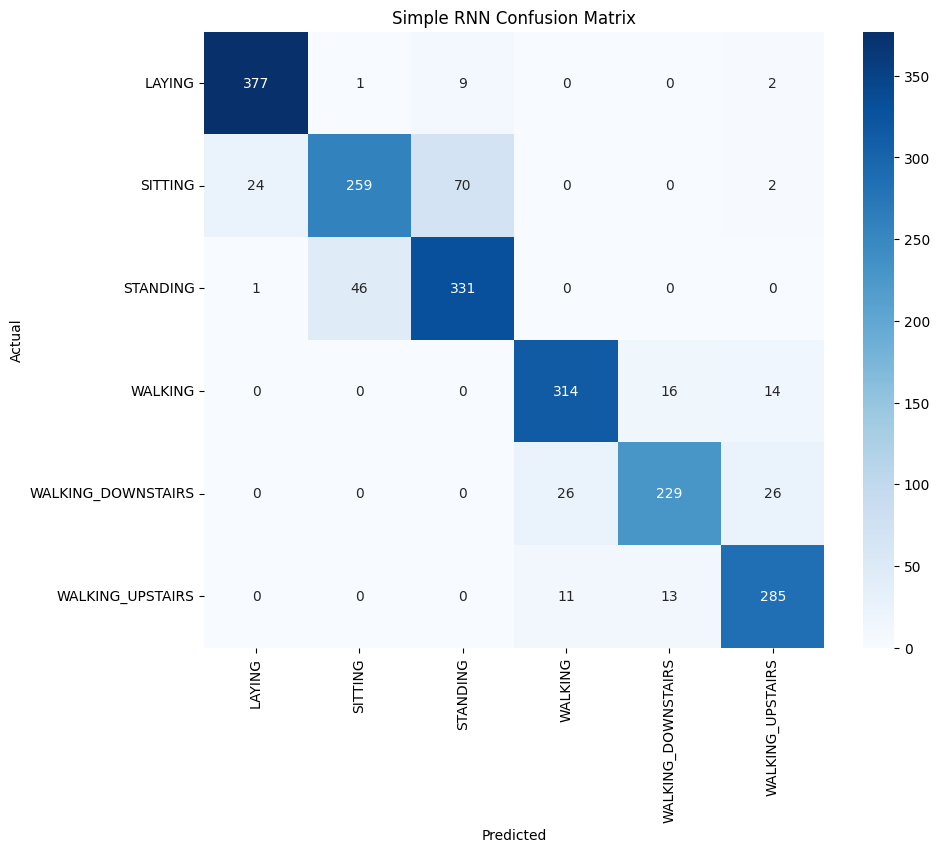

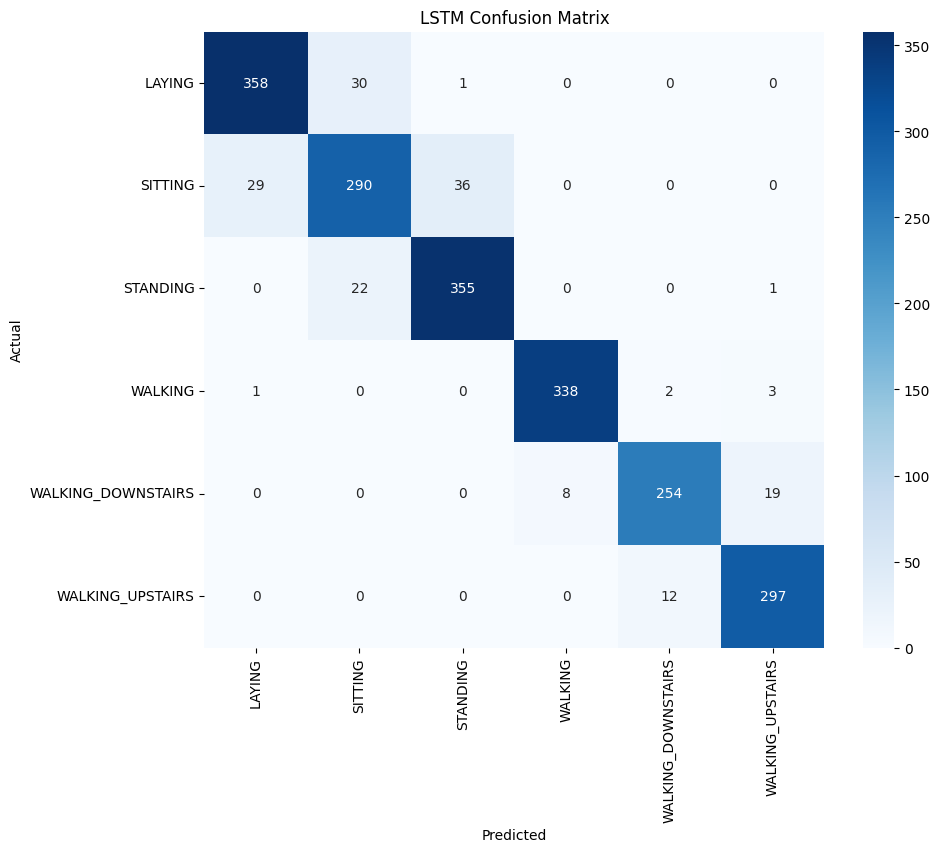

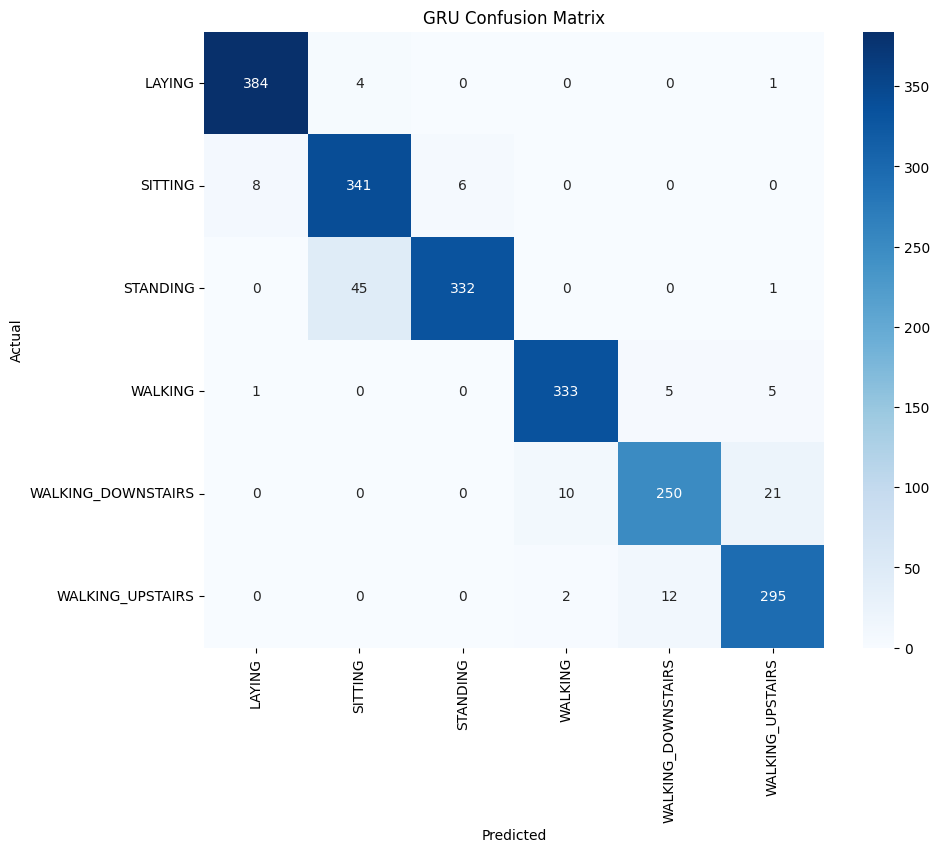

In [10]:
def plot_cm(cm, title):
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_cm(rnn_cm, 'Simple RNN Confusion Matrix')
plot_cm(lstm_cm, 'LSTM Confusion Matrix')
plot_cm(gru_cm, 'GRU Confusion Matrix')
